In [1]:
import numpy as np
from scipy.io import loadmat
from scipy import interpolate
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
# learned_graphs = np.load('./Outputs/graph_plot_learned_graph.npy')
learned_graphs = np.load('./Outputs/learned_graph.npy')
ground_truth_adj = np.array(loadmat('./Adj.mat')['A_Ground'])
flattened_adj = ground_truth_adj.flatten()

print(learned_graphs.shape)

(16000, 20, 20)


In [3]:
sensing_ratio = 1 + np.arange(80)
n_sensing = len(sensing_ratio)

epochs = 20
n_data = 10
n_pts = epochs * n_data

In [4]:
def smooth_curve(x, y, smooth_factor):
    spline = interpolate.UnivariateSpline(x, y)
    spline.set_smoothing_factor(smooth_factor)
    return spline(x)

In [5]:
def laplacian_to_adj(laplacian, threshold):
    adjacency = -(laplacian - (np.eye(ground_truth_adj.shape[0]) * laplacian))
    
    tmp_adj = np.sign(adjacency - threshold)
    tmp_adj[tmp_adj < 0] = 0.0
    return tmp_adj

In [6]:
f1_scores_plot = []
avg_f1_scores_plot = []
learned_lap_graphs = []

for n_psi, sen in enumerate(sensing_ratio):
    all_graphs = learned_graphs[n_psi * n_pts : (n_psi + 1) * n_pts, : , :]
    graphs = all_graphs[-n_data : , : , :]
    
    learned_lap_graphs.append(graphs)
    
    f1_scores = []
    adj_graphs = []
    
    s = int(np.sqrt(n_data))
    f_score_matrix = np.zeros(n_data)
    
    for i in range(n_data):
        adj_graph = laplacian_to_adj(graphs[i, : , :], 0.0)
        
        adj_graphs.append(adj_graph.flatten())
        f1_scores.append(f1_score(flattened_adj, adj_graphs[-1]))
    
    compare_graph = adj_graphs[0]
    for i, graph_1 in enumerate(adj_graphs):
        f_score_matrix[i] = f1_score(compare_graph, graph_1)
    
    print(f"For {sen}% sensing ratio:")
    
#     ax = sns.heatmap(f_score_matrix.reshape([s, s]), vmin = 0.0, vmax = 1.0)
#     plt.title("F-Score among graphs")
#     plt.show()
    
    avg_f_score = np.sum(f_score_matrix) / (n_data)
    avg_f1_scores_plot.append(avg_f_score)
    
    print(f"\nAverage F-Score among entries: {avg_f_score:.5f}")
    print(f"Average F-Score with Ground Truth graph: {np.average(f1_scores):.5f}\n\n")
    f1_scores_plot.append(np.average(f1_scores))

For 1% sensing ratio:

Average F-Score among entries: 0.96277
Average F-Score with Ground Truth graph: 0.84628


For 2% sensing ratio:

Average F-Score among entries: 0.94301
Average F-Score with Ground Truth graph: 0.83991


For 3% sensing ratio:

Average F-Score among entries: 0.95017
Average F-Score with Ground Truth graph: 0.82909


For 4% sensing ratio:

Average F-Score among entries: 0.93508
Average F-Score with Ground Truth graph: 0.82520


For 5% sensing ratio:

Average F-Score among entries: 0.93175
Average F-Score with Ground Truth graph: 0.81118


For 6% sensing ratio:

Average F-Score among entries: 0.91445
Average F-Score with Ground Truth graph: 0.79872


For 7% sensing ratio:

Average F-Score among entries: 0.93955
Average F-Score with Ground Truth graph: 0.79132


For 8% sensing ratio:

Average F-Score among entries: 0.92419
Average F-Score with Ground Truth graph: 0.79316


For 9% sensing ratio:

Average F-Score among entries: 0.93482
Average F-Score with Ground Truth 

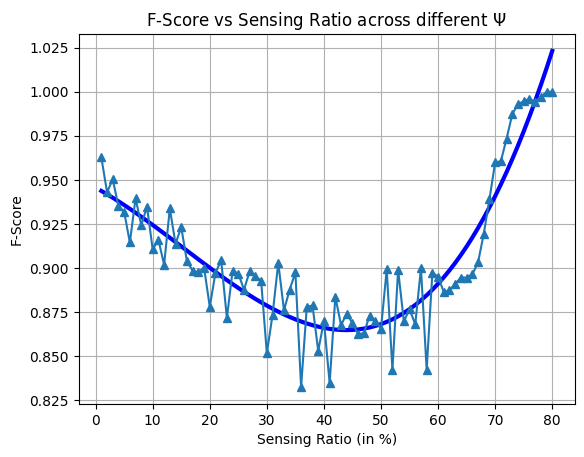

In [7]:
smooth_plot = smooth_curve(sensing_ratio, avg_f1_scores_plot, 0.1)

plt.plot(sensing_ratio, smooth_plot, 'b', lw = 3)
plt.plot(sensing_ratio, avg_f1_scores_plot, marker = "^")
plt.title(r"F-Score vs Sensing Ratio across different $\Psi$")
plt.xlabel("Sensing Ratio (in %)")
plt.ylabel("F-Score")
plt.grid()
# plt.savefig("./Plots/fscore_vs_sensing_ratio_among_graphs.png")
plt.show()

In [8]:
learned_lap_graphs = np.array(learned_lap_graphs)
f1_scores = []

for i_sen, rem in enumerate(sensing_ratio):
    graph_laplacians = np.squeeze(learned_lap_graphs[i_sen, :, :, :])
    avg_graph = np.sum(graph_laplacians, axis = 0) / graph_laplacians.shape[0]
    
    avg_graph_adj = laplacian_to_adj(avg_graph, 0.0)
    f1_scores.append(f1_score(flattened_adj, avg_graph_adj.flatten()))

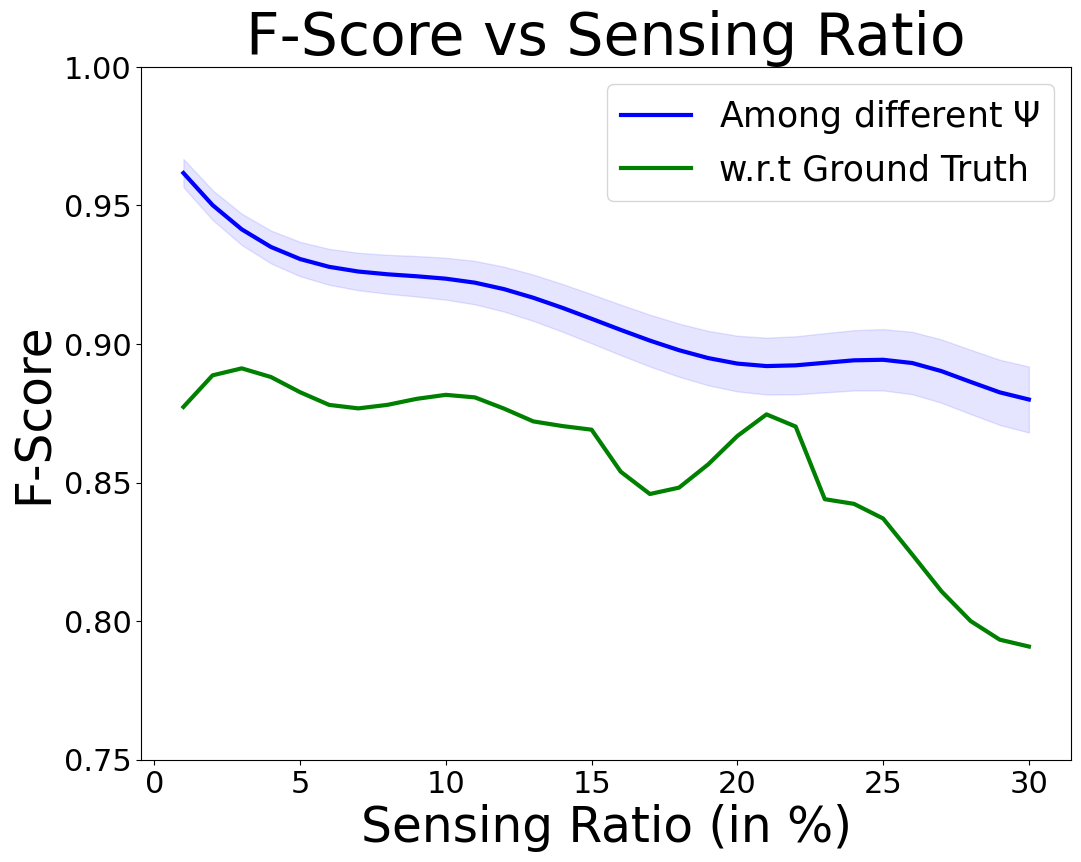

In [9]:
smooth_plot_among_psi = smooth_curve(sensing_ratio, avg_f1_scores_plot, 0.0134)
smooth_plot_ground_truth = smooth_curve(sensing_ratio, f1_scores, 0.001)

ci = np.abs(np.array(smooth_plot_among_psi) - np.array(avg_f1_scores_plot))

ci = smooth_curve(sensing_ratio, ci, 0.008)
y = smooth_plot_among_psi

plot_sr = 30
sr = sensing_ratio[ : plot_sr]

fig = plt.figure(figsize = [12, 9])

plt.rcParams['font.size'] = '22'
plt.plot(sr, smooth_plot_among_psi[ : plot_sr], 'b', label = r"Among different $\Psi$", linewidth = 3)
plt.fill_between(sr, (y-ci)[ : plot_sr], (y+ci)[ : plot_sr], color='blue', alpha = 0.1)
plt.plot(sr, smooth_plot_ground_truth[ : plot_sr], 'g', label = "w.r.t Ground Truth", linewidth = 3)
plt.title("F-Score vs Sensing Ratio", size = 42)
plt.xlabel("Sensing Ratio (in %)", size = 35)
plt.ylabel("F-Score", size = 35)
plt.legend(fontsize = 25, loc = 'upper right')
plt.ylim([0.75, 1.0])
plt.savefig("./../Plots/synthetic_fscore_vs_sr.pdf", bbox_inches='tight')

plt.show()

In [10]:
for i in range(len(smooth_plot_ground_truth)):
    print(i, smooth_plot_ground_truth[i], smooth_plot_among_psi[i], ci[i])

0 0.8772695723112015 0.9616494115972277 0.005072437997460981
1 0.8886710294065443 0.9500793957842846 0.005354545385925201
2 0.8911850044114086 0.9413352136740801 0.005636104854451429
3 0.8880713030330732 0.9349917155106943 0.005916807449313538
4 0.8825897309788174 0.9306237515382072 0.006196344216785399
5 0.8780000939559203 0.9278061720006994 0.006474406203140885
6 0.8767476773270383 0.9261138271422514 0.006750684454653868
7 0.8780196850763381 0.9251215672069434 0.007024870017598218
8 0.8801888008433635 0.9244042424388558 0.0072966539382478095
9 0.8816277082676589 0.9235367030820687 0.007565727262876514
10 0.880709090988768 0.9220937993806629 0.007831781037758206
11 0.8766512736128502 0.919759901655705 0.008094506309166756
12 0.8720551446125235 0.9166574605362083 0.008353594123376034
13 0.8703672334270216 0.9130184467281731 0.008608735526659915
14 0.8690629735853191 0.909074830937599 0.008859621565292266
15 0.853900644366031 0.9050585838704855 0.00910594328554697
16 0.8458567869624926 